In [34]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, 
    roc_auc_score, accuracy_score, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [35]:
spotify_df = pd.read_csv("data/spotify_df_cleaned.csv")
recommendationInfo_df = pd.read_csv("data/recommendation_info.csv")
playlists_df = pd.read_csv("data/spotify_df_cleaned.csv")

feature_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                   'speechiness', 'acousticness', 'instrumentalness', 
                   'liveness', 'valence', 'tempo', 'duration_ms']

X = spotify_df[feature_columns].values

In [ ]:
def create_training_pairs(n_positive=10000, n_negative=10000):
    """
    Create positive pairs (songs from same playlist) 
    and negative pairs (random songs from different contexts)
    Use spotify_df since it has both features and playlist info
    """
    pairs = []
    labels = []
    
    
    playlist_col = 'playlist_name'
    
    playlist_names = spotify_df[playlist_col].unique()
    

    for playlist in tqdm(playlist_names,):
        if len(pairs) >= n_positive:
            break
            
        playlist_songs = spotify_df[spotify_df[playlist_col] == playlist]
        
        if len(playlist_songs) < 2:
            continue
        
        matched = playlist_songs.index.tolist()
        
        if len(matched) >= 2:
            n_pairs = min(len(matched) - 1, 5)
            
            for i in range(n_pairs):
                if len(pairs) >= n_positive:
                    break
                    
                idx1 = matched[i]
                idx2 = matched[min(i + 1, len(matched) - 1)]
                
                features = np.concatenate([
                    X[idx1],
                    X[idx2]
                ])
                
                pairs.append(features)
                labels.append(1)  

    np.random.seed(42)
    
    n_current = len(pairs)
    while len(pairs) < n_current + n_negative:
        idx1 = np.random.randint(0, len(X))
        idx2 = np.random.randint(0, len(X))
        
        if idx1 != idx2:
            features = np.concatenate([
                X[idx1],
                X[idx2]
            ])
            
            pairs.append(features)
            labels.append(0) 
    
    
    return np.array(pairs), np.array(labels)

In [37]:
X_pairs, y_pairs = create_training_pairs(n_positive=8000, n_negative=8000)

100%|██████████| 109/109 [00:00<00:00, 4754.66it/s]


In [ ]:
#splitting data 
X_train, X_test, y_train, y_test = train_test_split(
    X_pairs, y_pairs, test_size=0.2, random_state=42, stratify=y_pairs
)

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")
print(f"Train positive ratio: {np.mean(y_train)}%")
print(f"Test positive ratio: {np.mean(y_test)}%")

Training set: 6829 samples
Test set: 1708 samples
Train positive ratio: 0.06296675940840533
Test positive ratio: 0.0626463700234192


In [39]:
baseline_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
)

In [40]:
baseline_rf.fit(X_train, y_train)

# Predictions
y_train_pred = baseline_rf.predict(X_train)
y_test_pred = baseline_rf.predict(X_test)
y_train_proba = baseline_rf.predict_proba(X_train)[:, 1]
y_test_proba = baseline_rf.predict_proba(X_test)[:, 1]

# Basic metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

In [ ]:
print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy:  {test_acc}")
print(f"Train AUC:      {train_auc}")
print(f"Test AUC:       {test_auc}")


Train Accuracy: 0.9372
Test Accuracy:  0.9374
Train AUC:      1.0000
Test AUC:       0.6100


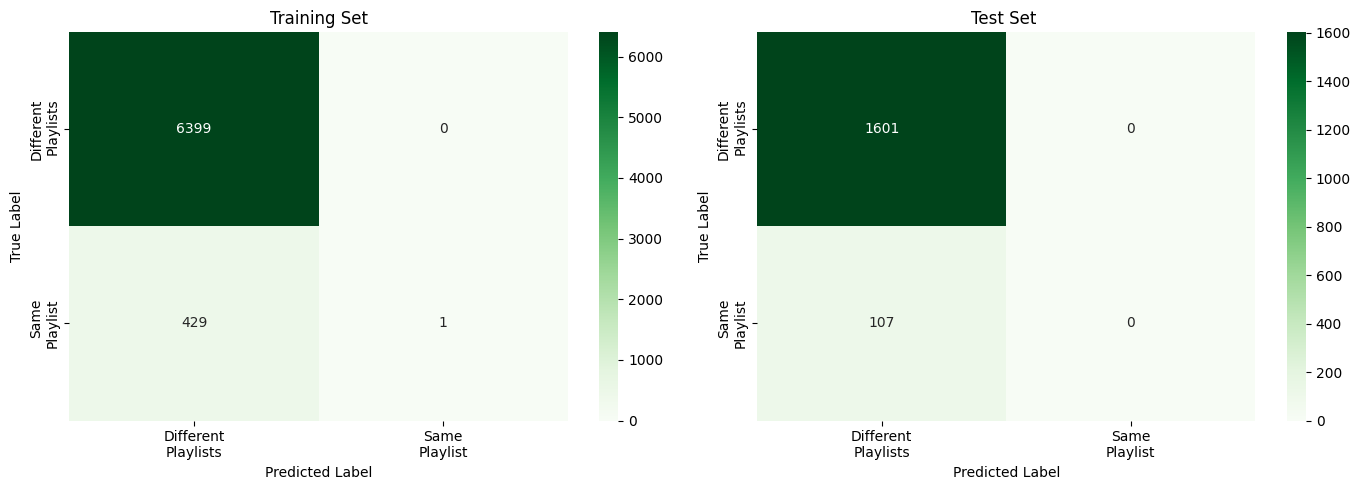


--- Classification Report (Test Set) ---
                     precision    recall  f1-score   support

Different Playlists       0.94      1.00      0.97      1601
      Same Playlist       0.00      0.00      0.00       107

           accuracy                           0.94      1708
          macro avg       0.47      0.50      0.48      1708
       weighted avg       0.88      0.94      0.91      1708



/Users/andrewlaskin/Desktop/CIS4930-ML-Final-Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/andrewlaskin/Desktop/CIS4930-ML-Final-Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/andrewlaskin/Desktop/CIS4930-ML-Final-Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Training Set')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['Different\nPlaylists', 'Same\nPlaylist'])
axes[0].set_yticklabels(['Different\nPlaylists', 'Same\nPlaylist'])

# Test confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Test Set ')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_xticklabels(['Different\nPlaylists', 'Same\nPlaylist'])
axes[1].set_yticklabels(['Different\nPlaylists', 'Same\nPlaylist'])

plt.tight_layout()
plt.show()

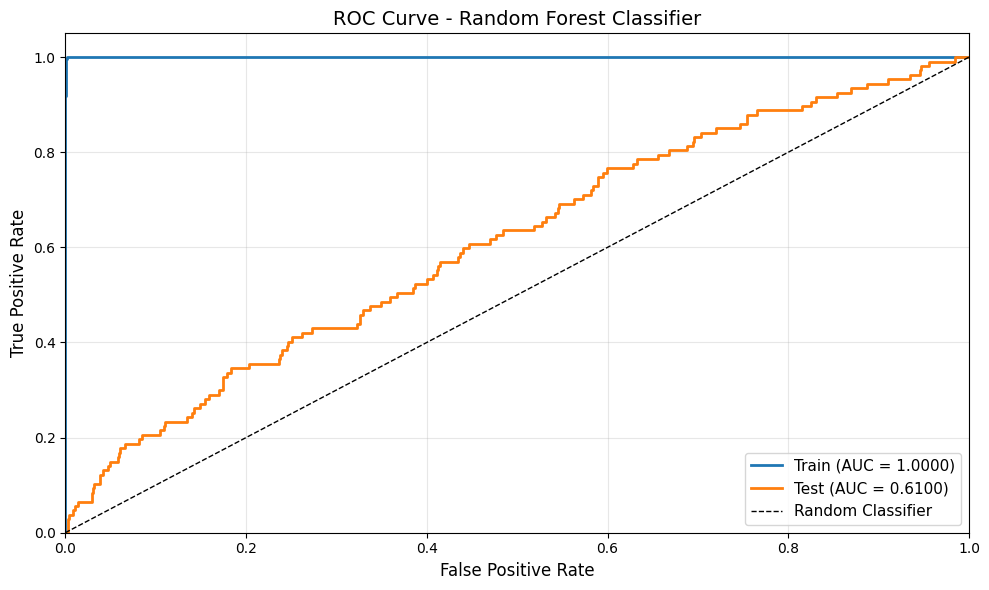


ROC AUC Scores:
  Training:   1.0000
  Test:       0.6100
  Difference: 0.3899


In [43]:
# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {train_auc:.4f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Random Forest Classifier', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC AUC Scores:")
print(f"  Training:   {train_auc:.4f}")
print(f"  Test:       {test_auc:.4f}")
print(f"  Difference: {abs(train_auc - test_auc):.4f}")


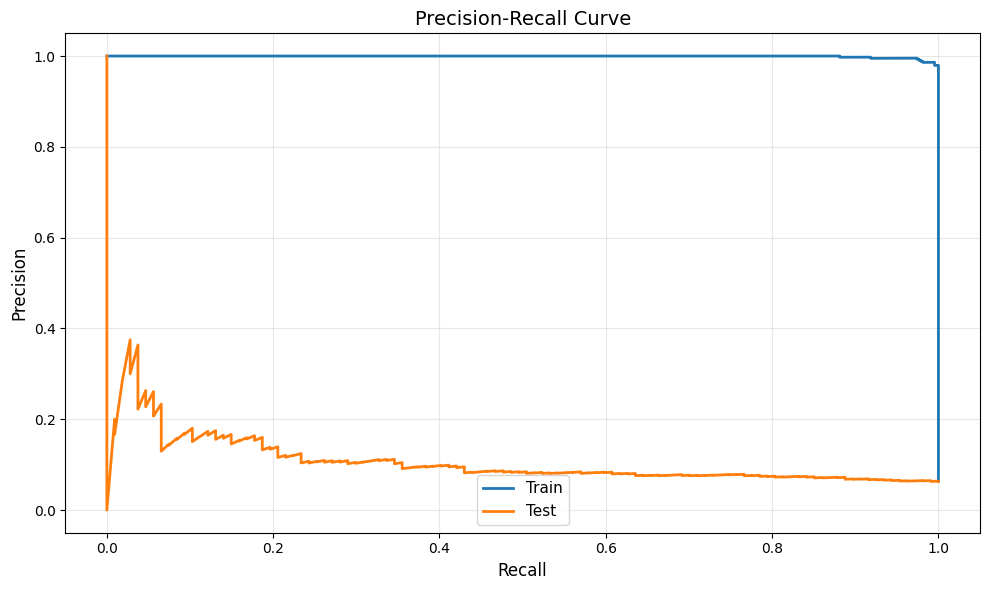

In [44]:

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall_train, precision_train, label='Train', linewidth=2)
plt.plot(recall_test, precision_test, label='Test', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc="best", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

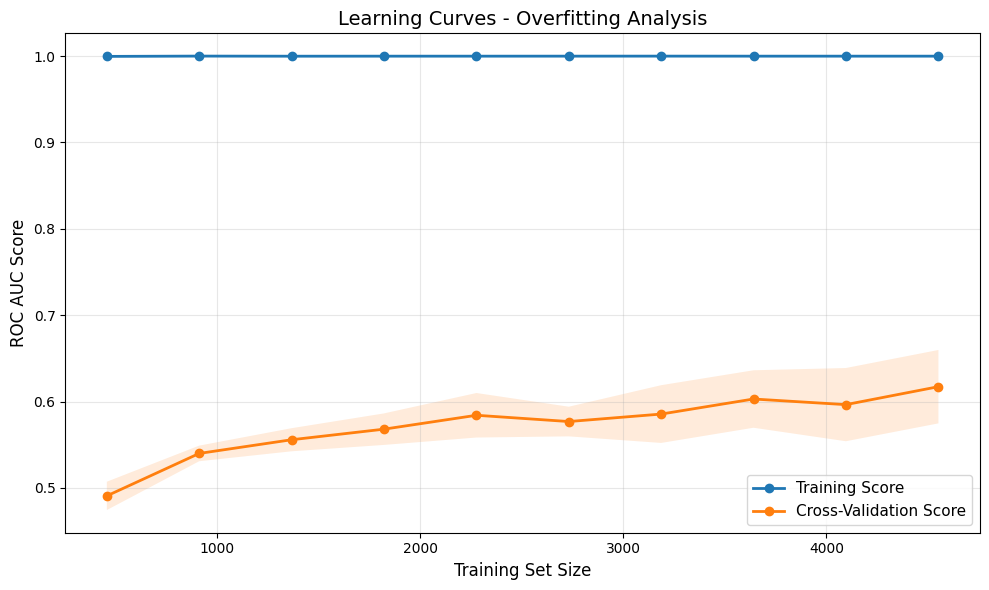

In [45]:
#Learning Curves 
train_sizes, train_scores, val_scores = learning_curve(
    baseline_rf, 
    X_train, 
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)

plt.plot(train_sizes, val_mean, label='Cross-Validation Score', marker='o', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15)

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('ROC AUC Score', fontsize=12)
plt.title('Learning Curves - Overfitting Analysis', fontsize=14)
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [46]:
gap = train_mean[-1] - val_mean[-1]
print(f"\n--- Overfitting Analysis ---")
print(f"Final training score:        {train_mean[-1]:.4f}")
print(f"Final cross-validation score: {val_mean[-1]:.4f}")
print(f"Gap (train - CV):            {gap:.4f}")

if gap < 0.02:
    print("✓ Model shows MINIMAL overfitting")
elif gap < 0.05:
    print("⚠ Model shows SLIGHT overfitting")
elif gap < 0.10:
    print("⚠ Model shows MODERATE overfitting")
else:
    print("✗ Model shows SIGNIFICANT overfitting")



--- Overfitting Analysis ---
Final training score:        0.9999
Final cross-validation score: 0.6172
Gap (train - CV):            0.3827
✗ Model shows SIGNIFICANT overfitting
